# Homework 1
## Introduction
### Important dates
* Homework release: Thursday, 3rd October 2019
* **Homework due**: Wednesday, 16th October 2019 (23:59 hours, 11:59 PM)
* Peer review due: Wednesday, 23rd October 2019 (23:59 hours, 11:59 PM)
* Grading release: Wednesday, 30th October 2019

### Description

The data you'll be working with comes from multiple sources. The main data source will be [DBLP](https://dblp.uni-trier.de/), a database of publications from major computer science journals and conferences. A subset of DBLP, which you will use in this assignment, is provided to you via a [google drive folder](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view). Later on, you will enrich the DBLP data with a dataset on conference rankings and with the proceedings of the [NIPS conference](https://nips.cc/) [1] ('proceedings' is another word for the set of papers published at an academic conference). After loading and cleaning the data, you will answer various questions about its contents.

**Some rules:**
- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you have to justify your choice.
- Make sure you use the data folder provided in the repository in *read-only* mode.
- Be sure to provide explanations for your answers. A notebook that only has code cells will not suffice.
- Also, be sure to *hand in a fully-run and evaluated notebook*. We will not run your notebook for you, we will grade it as is, which means that only the results contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells. In order to check whether everything looks as intended, you can check the rendered notebook on the GitHub website once you have pushed your solution there.

[1] Note that NIPS was renamed to NeurIPS in 2018, but for simplicity, whenever we say 'NIPS', we really mean 'NIPS and NeurIPS'.

## Task A. Getting a sense of the dataset

### A1. Loading the data
Download the DBLP dataset (available on [google drive](https://drive.google.com/file/d/1Kci8joML74tCSzuBbhxtd1ylR4f0dlm6/view)) and load it into a Pandas dataframe. A row of your dataframe should look as follows:

| paper id | author names | publication year | paper title | 
| :----:|:-------------:| :-----:|:-----:|
| conf/nips/doe1036 | [John Doe, Jane Doe] | 2003 | Some Catchy Title: An Expanded and Boring Title | 


1. Filter the papers: keep only conference papers. For each of the remaining ones, find the acronym of the conference where it was published. Retain only those papers that have been published in the conferences listed in `data/list_of_ai_conferences.txt`. Additionally, add a column named 'conference' to your dataframe.   
_Hint: The `paper id` tells you whether a paper was published at a conference, and if so, at which one._

2. Report the overall number of papers in the filtered dataset, as well as the number of papers per conference.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup

In [2]:
papers = pd.read_csv('data/dblp.tsv', delimiter='\\t')
conf_data = open('data/list_of_ai_conferences.txt','r')
conf_lines = conf_data.read().splitlines()
papers_conf = papers[papers['id'].str.startswith('conf')]
papers_conf2 = pd.concat([papers_conf, papers_conf['id'].str.split('/',expand=True)],axis=1).drop([0,2],axis=1).rename(columns={1:'conference'})
papers_list = papers_conf2[papers_conf2['conference'].isin(conf_lines)]
print(papers_list.groupby(papers_list['conference']).size())
print('total =',len(papers_list), 'papers')

/mnt/c/linux_home/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


conference
aaai      10796
aamas       367
accv       2390
acl        6330
cvpr      12853
emnlp      3299
fgr        1383
icann      3134
iccbr       863
iccv       4179
icml       5017
iconip     4985
icra      21585
ida         712
ijcai      9669
ilp         679
ksem        635
naacl      3310
nips       8445
pricai     1372
dtype: int64
total = 102003 papers


### A2. An author-centric look
The dataframe you created above was a paper-centric one. Now, we want you to create a new dataframe centered around authors. Do this by expanding the author names in the lists in the 2nd column into separate rows. That is, if a paper has 3 authors, turn that row into 3 rows, each of which only contains one of the author names (along with the rest of the paper information, i.e., title, conference and year). Keep both dataframes, we are going to need both of them.    
**Report the number of unique authors.**

In [3]:
''' Add your code here'''
p_authors = papers_list.copy()
p_authors['authors'] = p_authors['authors'].str.strip('[').str.strip(']')
p_authors2 = pd.concat([p_authors, p_authors['authors'].str.split(',',expand=True)],axis=1).drop(['authors'],axis=1)
p_authors3 = p_authors2.iloc[:,4:].stack().str.strip('"').str.strip('[').str.strip(']')
# p_authors3.replace('', np.nan, inplace=True)
# p_authors3.dropna().nunique()
print(p_authors3.unique())
print(p_authors3.nunique())

["'Yoshinori Kuno'" " 'Yasukazu Okamoto'" " 'Satoshi Okada'" ...
 "'Johannes Hellrich'" " 'Thomas Lin'" "'Catalina Barbu'"]
129608


In [4]:
# p_authors3.shape[0]
# papers_list.shape[0]
# p_authors2.head()

### A3. Is your data analysis-friendly?

Using an appropriate view of your data (paper-centric or author-centric), solve the following tasks:

1. Plot the number of papers per author and analyze it. Do you observe any outliers? Can you identify the source of the problem? Please elaborate!   
_Hint: To find out where the problem comes from, try performing an analysis at the conference or year level._   
Make sure you remove this inconsistency from your dataframe before moving to the next step, and also create a new plot of the number of papers per author after fixing the problem.   

2. Plot the number of papers per year. Do you observe any inconsistency in the output? Real-world data is usually messy, with typos, erroneous entries, and sometimes issues that make even loading the data problematic. Fix any errors that you encounter along the way, find ways to clean the attribute `year`, and redo the plot of the number of papers per year.   

3. Machine learning (ML) has been one of the hottest topics within the broader area of AI recently, so let’s see if this is reflected in the number of ML publications. In particular, let’s focus on the two major ML conferences, NIPS and ICML: make a new dataframe with only NIPS and ICML papers (let’s call these the “ML papers”), plot the number of ML papers over time, and analyze and discuss the plot. Do you observe anything odd in this plot? What causes these problems?   
_Hint: Try to perform an analysis at the conference or year level._   

4. By now, you may have noticed that some conferences are not fully represented in the DBLP dataset. Complete the paper-centric dataframe by scraping the full NIPS data from the online proceedings at https://papers.nips.cc/ (maintain the same schema used in your previous dataframes, but fill in missing values). After this step, remove any remaining papers that have missing values. Redo the plots of steps A3.2 and A3.3 after fixing the issue.   

_Note: In order to avoid re-running the cleaning part of the notebook every time, you could save the results at this point as a pickle file! Also, propagating your cleaning to both dataframes might prove useful later on._

***A3.1***

 'Luc Van Gool'              216
 'Thomas S. Huang'           185
 'Toshio Fukuda'             163
 'Michael I. Jordan'         162
 'Xiaoou Tang'               147
 'Shuicheng Yan'             146
 'Takeo Kanade'              145
 'Larry S. Davis'            142
 'Trevor Darrell'            142
 'Vijay Kumar 0001'          141
 'Roland Siegwart'           137
 'Wolfram Burgard'           136
 'Christopher D. Manning'    133
 'Andrew Zisserman'          132
 'Eric P. Xing'              131
 'Marc Pollefeys'            130
 'Martial Hebert'            129
 'Dan Roth'                  129
 'Dan Klein'                 123
 'Bernhard Schölkopf'        123
 'Lawrence Carin'            118
 'Rama Chellappa'            117
 'Dacheng Tao'               115
 'Ming-Hsuan Yang 0001'      115
 'Noah A. Smith'             114
 'Xilin Chen'                112
 'Daniela Rus'               111
 'Mubarak Shah'              111
 'Jitendra Malik'            111
 'Zhi-Hua Zhou'              110
          

{'whiskers': [<matplotlib.lines.Line2D at 0x7f341e0ce4e0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f341e0cb860>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f341e0ced68>],
 'medians': [<matplotlib.lines.Line2D at 0x7f341e0cb240>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f341e0c84e0>],
 'means': []}

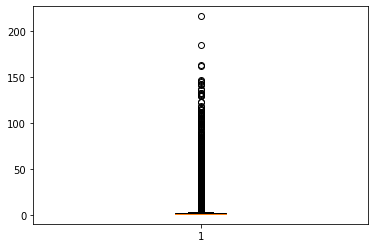

In [5]:
''' Add your code here '''
# p_a31 = p_authors3.copy()
# p_a312 = p_a31.groupby(p_a31).count()
# print(p_a312.sort_values(ascending=False))
# plt.boxplot(p_a312)

# Exclude outliers
p_a313 = p_authors2.copy().iloc[:,4:].stack().str.strip('"').str.strip('[').str.strip(']')
p_a313.replace('', np.nan, inplace=True)
p_a313.dropna()
p_a313 = p_a313.groupby(p_a313).count()
p_a314 = p_a313[p_a313 < 300]
print(p_a314.sort_values(ascending=False))
plt.boxplot(p_a314)

***A3.2***

year    
2018  id    8936
2017  id    7213
2015  id    6134
2016  id    5975
2013  id    4941
2014  id    4540
2012  id    4462
2011  id    4360
2007  id    4336
2009  id    3800
2010  id    3752
2006  id    3656
2005  id    3438
2008  id    3342
2004  id    2681
2003  id    2459
1998  id    2390
2001  id    2235
1997  id    2212
2000  id    1815
1999  id    1815
2002  id    1727
1996  id    1682
1993  id    1496
1995  id    1402
1994  id    1368
1991  id    1364
1992  id    1078
1989  id    1050
1990  id     974
1988  id     894
1987  id     850
?     id     634
1986  id     583
1985  id     472
1983  id     391
1981  id     257
1979  id     256
1977  id     236
1975  id     149
1984  id     145
1982  id     145
1980  id     141
1973  id      86
1971  id      67
1969  id      64
dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x7f341e0f2630>,
 'caps': [<matplotlib.lines.Line2D at 0x7f341e0f0978>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f341e0f2ef0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f341e0f0080>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f341e16e5f8>],
 'means': []}

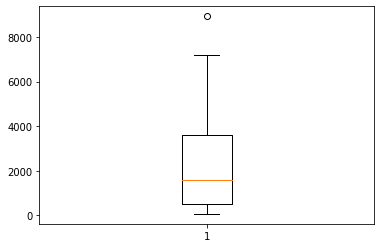

In [6]:
''' Add your code here '''
p_a32 = papers_list.copy()
p_a32 = p_a32.groupby('year').count()
p_a322 = p_a32.iloc[:,:1].stack()
# print(p_a322.sort_values(ascending=False))
# plt.bar(p_a32.index,p_a32.title)
# plt.boxplot(p_a32)
# inconsistency: description of years, e.g. 2018, 2018.0, 18, <i>2018<-i>

p_a323 = papers_list.copy()
n = np.arange(0,19)
n_str = [str(18-i).zfill(2) for i in n]
for yy in n_str:
    p_a323.loc[p_a323['year'].str.contains(yy)==True, 'year'] = yy
for yy in n_str:
    p_a323.loc[p_a323['year'].str.startswith(yy)==True, 'year'] = '20'+yy
n = np.arange(69,100)
n_str2 = [str(i) for i in n]
for yy in n_str2:
    p_a323.loc[p_a323['year'].str.contains(yy)==True, 'year'] = yy
for yy in n_str2:
    p_a323.loc[p_a323['year'].str.startswith(yy)==True, 'year'] = '19'+yy
p_a323.loc[p_a323['year'].str.contains('<')==True, 'year'] = '?'
p_a324 = p_a323.groupby('year').count()
p_a325 = p_a324.iloc[:,:1].stack()
print(p_a325.sort_values(ascending=False))
plt.boxplot(p_a325)

In [7]:
p_a323.shape[0]

102003

***A3.3***

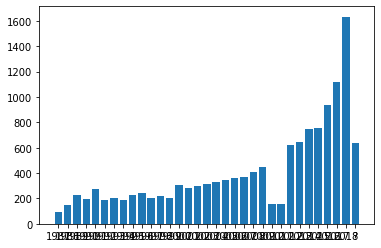

In [8]:
mlconf = ['icml', 'nips']
''' Add your code here '''
p_a33 = p_a323[p_a323['conference'].str.contains('|'.join(mlconf))]
p_a332 = p_a33.groupby('year').count()
plt.bar(p_a332.index,p_a332.conference)
p_a333 = p_a332.iloc[:,:1].stack()
# print(p_a333.sort_values(ascending=False))

<BarContainer object of 32 artists>

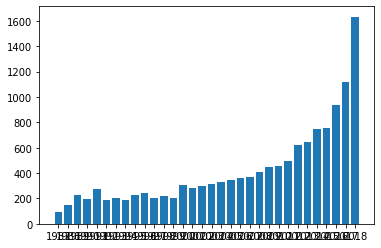

In [9]:
p_a334 = p_a323.copy()
p_a334.loc[p_a334['year']=='?', 'year'] = '20'+p_a334['id'].str[-2:]
p_a334.loc[p_a334['year']=='20ts', 'year'] = '2009'
p_a334.loc[p_a334['year']=='200a', 'year'] = '2010'
p_a334.loc[p_a334['year']=='20oa', 'year'] = '2008'
p_a335 = p_a334[p_a334['conference'].str.contains('|'.join(mlconf))].groupby('year').count()
plt.bar(p_a335.index,p_a335.conference)
# p_a336 = p_a335.iloc[:,:1].stack()
# print(p_a336.sort_values(ascending=False))

***A3.4***

,authors,title,year
0,'Francis Bach',Efficient Algorithms for Non-convex Isotonic R...,2018
1,"'Jianlong Chang', 'Jie Gu', 'Lingfeng Wang', '...",Structure-Aware Convolutional Neural Networks,2018
2,"'Guangrun Wang', 'jiefeng peng', 'Ping Luo', '...",Kalman Normalization: Normalizing Internal Rep...,2018
3,"'Constantinos Daskalakis', 'Nishanth Dikkala',...",HOGWILD!-Gibbs can be PanAccurate,2018
4,"'Seonghyeon Nam', 'Yunji Kim', 'Seon Joo Kim'",Text-Adaptive Generative Adversarial Networks:...,2018


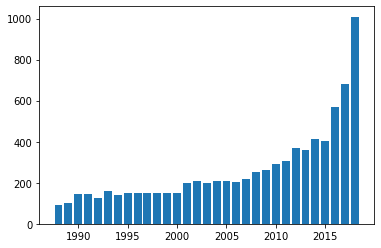

In [10]:
''' Add your code here '''
URL='https://papers.nips.cc/'
r = get(URL)
page_body = r.text
page_body[:300]
soup = BeautifulSoup(page_body, 'html.parser')
soup.title
all_links = soup.find_all('a')

publications_list = []
year = 2018
for link in all_links:
    if link.get('href').startswith('/book/advances'):
        URL2 = link.get('href')
        URL3 = URL + URL2 
        r2 = get(URL3)
        page_body2 = r2.text
        page_body2[:300]
        soup2 = BeautifulSoup(page_body2, 'html.parser')
        all_li = soup2.find_all('li')
        for p in all_li:
            if not p.text == 'Books':
                all_a = p.find_all('a')
                a_list = p.find_all('a', class_='author')
                authors = [author.text for author in a_list]
                title = all_a[0].text
                publications_list.append({'title':str(title),
                                          'authors':str(authors),
                                          'year':year})
        year = year -1

publications = pd.DataFrame.from_dict(publications_list)
publications.head(1000)

p_NIPS = publications.copy()
p_NIPS['authors'] = p_NIPS['authors'].str.strip('[').str.strip(']')
p_NIPS2 = pd.concat([p_NIPS, p_NIPS['authors'].str.split(',',expand=True)],axis=1).drop(['authors'],axis=1)
p_NIPS3 = p_NIPS2.groupby('year').count()
plt.bar(p_NIPS3.index,p_NIPS3.title)
p_NIPS.head()


#p_NIPS.isnull().sum()
# p_NIPS2 = p_NIPS.fillna
# p_NIPS2 = p_NIPS2.dropna
# p_NIPS2 = p_NIPS.groupby('year').count()
# plt.bar(p_NIPS2.index,p_NIPS2.authors)

### A4. Author activity

For each author, calculate their normalized paper count, defined as the total number of papers divided by the author’s period of activity. An author’s period of activity is defined as the number of years between the earliest and latest papers of this author. Plot the distribution of the normalized paper count. What is the appropriate scale for the axes? Does the distribution (roughly) follow a particular law, and if yes, which one?

(array([1.23539e+05, 6.78600e+03, 3.33000e+02, 8.90000e+01, 2.70000e+01,
        6.00000e+00, 4.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.05128205,  1.57115385,  3.09102564,  4.61089744,  6.13076923,
         7.65064103,  9.17051282, 10.69038462, 12.21025641, 13.73012821,
        15.25      ]),
 <a list of 10 Patch objects>)

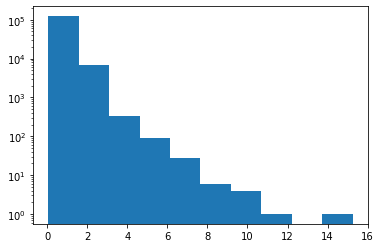

In [13]:
''' Add your code here '''
# p_a4 = p_a323.copy().drop('id',axis=1) # p_a323 = list: year revised
# p_a42 = p_a4.set_index(['conference']).drop('nips', axis=0)
# p_a42.reset_index(inplace=True)
# # p_a42[p_a42['conference'].str.contains('nips')]
# p_a43 = pd.DataFrame(p_a42,columns=['year','title','conference','authors'])
# p_a43['year'] = p_a43['year'].astype(np.int64)
# p_a44 = p_NIPS.copy()
# p_a45 = pd.DataFrame(p_a44,columns=['year','title','conference','authors'])
# p_a45['conference']='nips'
# p_a46 = pd.concat([p_a43,p_a45]) # connect dataframes: p_a323.drop(nips)+p_NIPS
# p_a47 = pd.concat([p_a46, p_a46['authors'].str.split(',',expand=True)],axis=1).drop(['authors'],axis=1)#.iloc[:,:4] #1st author, change number in iloc to change number of authors
# p_a48= p_a47.set_index(['year', 'title','conference']).stack().str.strip('"').str.strip('[').str.strip(']')
# p_a48.replace('', np.nan, inplace=True)
# p_a48.dropna()
# p_a49 = p_a48.reset_index().rename(columns={0: 'author'}).iloc[:,[0,4]]
# ct = p_a49.groupby('author').count().rename(columns={'year': 'ct'})
# mx = p_a49.groupby('author').max().rename(columns={'year': 'max'})
# mn = p_a49.groupby('author').min().rename(columns={'year': 'min'})
# p_a410=pd.concat([ct,mx,mn], axis=1)
# p_a410['np']=p_a410['ct'] / (p_a410['max'] - p_a410['min'] +1)
# # print(p_a410.sort_values('np'))
# p_a411 = p_a410[p_a410.np < 16] #delete outliers
plt.hist(p_a411.np,log=True)
# log-normal dist.

In [374]:
p_a49.head()

,year,author
0,1990,'Yoshinori Kuno'
1,1990,'Yasukazu Okamoto'
2,1990,'Satoshi Okada'
3,1999,'Sundar Vedula'
4,1999,'Simon Baker'


## Task B. Ranking authors

As you may know, there exist rankings for universities, which represent their relative quality and are used to compare the performance of different universities. In the same vein, there are rankings for conferences and journals, which represent the importance and impact of each conference or journal, and therefore allow for approximate comparisons. In this part, you will rank authors based on different aspects of their research output.

### B1. A Naïve Score

In the absence of citation counts, it is hard to objectively rank the authors based on the impact of their contributions to the field of AI research. A naïve way would be to rank them based on their number of published papers. Obtain such a ranking and analyze your result. Identify and explain some obvious limitations of this scheme.

In [284]:
''' Add your code here '''
p_b1 = p_a46.copy()
p_b12 = pd.concat([p_b1, p_b1['authors'].str.split(',',expand=True)],axis=1).drop(['authors'],axis=1)
p_b13 = p_b12.set_index(['year', 'title','conference']).stack().str.strip('"').str.strip('[').str.strip(']')
p_b13.replace('', np.nan, inplace=True)
p_b13.dropna()
p_b14 = p_b13.reset_index().rename(columns={0: 'author'}).iloc[:,[0,4]]
p_b15 = p_b14.groupby('author').count().rename(columns={'year': 'ct'})
p_b15 = p_b15[p_b15.ct < 220] #delete outliers
print(p_b15.sort_values('ct',ascending=False).head(20))

                            ct
author                        
 'Luc Van Gool'            211
 'Thomas S. Huang'         184
 'Toshio Fukuda'           163
 'Michael I. Jordan'       162
 'Xiaoou Tang'             147
 'Shuicheng Yan'           146
 'Takeo Kanade'            145
 'Larry S. Davis'          142
 'Trevor Darrell'          142
 'Vijay Kumar 0001'        141
 'Roland Siegwart'         137
 'Wolfram Burgard'         136
 'Christopher D. Manning'  132
 'Andrew Zisserman'        132
 'Eric P. Xing'            131
 'Marc Pollefeys'          130
 'Martial Hebert'          129
 'Dan Roth'                129
 'Bernhard Schölkopf'      124
 'Dan Klein'               123


### B2. H5-index

Another way to score and rank authors could be based on the quality of the conferences and journals where they publish their papers. For this task, you have to use the H5-index score from AMiner (https://aminer.org/ranks/conf) (another database of scholarly publications), which captures the quality of academic conferences: the higher the H5-index, the better the conference.
1. Load the AMiner dataset ( *'aminer_ai.tsv'* available in the folder ``data/``), which contains H5-index values for AI conferences. Load it into a new Pandas dataframe, and join it with the author-centric DBLP dataframe.
2. Calculate a *'new'* author ranking (give each author a score, by which the authors are then sorted in order to obtain the ranking), where each author's score is the sum of the H5-indices of all their papers (the H5-index of a paper being the H5-index of the conference it is published in).
3. Analyze your new, H5-index-based author ranking and explain how and why your results are different from the previous ranking. Do you see any differences in the top-20 authors based on the H5-index-based ranking and the one produced using publication counts? If yes, list the authors that are ranked in the top 20 based on publication counts but absent in the top 20 based on the H5-index-based ranking. Identify the ranks of these authors in the ranking produced by the H5-index based ranking scheme.
4. Now, take the authors in the file `data/list_of_selected_authors.txt`, and compute their rankings using the two (naïve and H5-index-based) ranking schemes. What do you observe? Explain the potential dangers of the naïve, paper-count-based score.
5. On the flip side, do you see any potential dangers of using the H5-index-based score?   
_Hint: Analyze the conferences in which the top ranked authors publish. Investigate the effect of the conferences in which these authors publish more frequently on the obtained ranking._

***B2.1***

In [14]:
''' Add your code here '''
aminer = pd.read_csv('data/aminer_ai.csv',sep=';')
aminer = aminer.rename(columns={'Short Name': 'conference'})
aminer['conference'] = aminer['conference'].str.lower()
aminer.dropna(how='any', inplace = True)
aminer2 = aminer[aminer['conference'].str.match('|'.join(conf_lines))]
p_b21 = p_a46.copy()
p_b212 = pd.concat([p_b21, p_b21['authors'].str.split(',',expand=True)],axis=1).drop(['authors'],axis=1)
p_b213 = pd.merge(p_b212,aminer2,how="outer", on = "conference").drop(['Rank','Conference (Full Name)'],axis=1)

In [15]:
p_b213.head(1)

,year,title,conference,0,1,2,3,4,5,6,...,68,69,70,71,72,73,74,75,76,H5-Index
0,1990,Object recognition using a feature search stra...,iccv,['Yoshinori Kuno','Yasukazu Okamoto','Satoshi Okada'],None,None,None,None,...,None,None,None,None,None,None,None,None,None,58


***B2.2***

In [387]:
''' Add your code here '''
# p_b22 = p_b213.set_index(['year', 'title','conference','H5-Index']).stack().str.strip('"').str.strip('[').str.strip(']')
# p_b22.replace('', np.nan, inplace=True)
# p_b22.dropna()
# p_b222 = p_b22.reset_index().rename(columns={0: 'author'})
# ct_b223 = p_b222.groupby('author').count().rename(columns={'year': 'ct'})
# mean_b223 = p_b222.groupby('author').mean().rename(columns={'H5-Index': 'H5_mean'})
# ymax_b223 = p_b222.groupby('author').max().rename(columns={'year': 'year_max'})
# ymin_b223 = p_b222.groupby('author').min().rename(columns={'year': 'year_min'})
p_b224 = pd.concat([ct_b223,mean_b223,ymax_b223,ymin_b223], axis=1).drop(['title','conference','H5-Index','year','level_4'],axis=1)
p_b224['H5_score'] = p_b224['ct'] * p_b224['H5_mean']
p_b224 = p_b224[p_b224.H5_score < 20000] #delete outliers
print(p_b224['H5_score'].sort_values(ascending=False).head(20))

author
 'Luc Van Gool'            18100.0
 'Thomas S. Huang'         13991.0
 'Xiaoou Tang'             13019.0
 'Shuicheng Yan'           11660.0
 'Trevor Darrell'          11495.0
 'Larry S. Davis'          11131.0
 'Marc Pollefeys'          10911.0
 'Martial Hebert'          10227.0
 'Takeo Kanade'            10216.0
 'Mubarak Shah'            10112.0
 'Andrew Zisserman'         9838.0
 'Pascal Fua'               9830.0
 'Jitendra Malik'           9672.0
 'Toshio Fukuda'            9454.0
 'Xiaogang Wang'            9280.0
 'Ming-Hsuan Yang 0001'     9184.0
 'Bernt Schiele'            9098.0
 'Rama Chellappa'           8868.0
 'Alan L. Yuille'           8609.0
 'Michael I. Jordan'        8569.0
Name: H5_score, dtype: float64


In [389]:
p_b224.head()

,ct,H5_mean,year_max,year_min,H5_score
author,,,,,
"""""Aaron D'Souza",3,57.333333,2008,2006,172.0
"""""Abidalrahman Moh'd",1,45.000000,2016,2016,45.0
"""""Alan O'Connor",1,58.000000,2004,2004,58.0
"""""Alden D'Souza",1,58.000000,2011,2011,58.0
"""""Alexander M. Formal'sky",3,58.000000,1998,1997,174.0


***B2.3***

In [390]:
''' Add your code here '''
p_b23 = p_b224.copy()
p_b232 = p_b23.sort_values('H5_score',ascending=False)
p_b232['H5_rank'] = np.arange(1,len(p_b23)+1)
p_b233 = p_b232.sort_values('ct',ascending=False)
p_b233['Npapers_rank'] = np.arange(1,len(p_b23)+1)
p_b233[(p_b233['Npapers_rank'] < 21) & (p_b233['H5_rank'] > 20)]

,ct,H5_mean,year_max,year_min,H5_score,H5_rank,Npapers_rank
author,,,,,,,
'Vijay Kumar 0001',141,58.283688,2018,1989,8218.0,21,10
'Roland Siegwart',137,59.204380,2018,1991,8111.0,23,11
'Wolfram Burgard',136,56.191176,2018,1998,7642.0,27,12
'Christopher D. Manning',132,41.666667,2018,2000,5500.0,54,14
'Eric P. Xing',131,57.206107,2018,2005,7494.0,31,15
'Dan Roth',129,40.410853,2018,1994,5213.0,64,18
'Bernhard Schölkopf',124,54.733871,2018,1996,6787.0,35,19
'Milind Tambe',123,34.471545,2018,1988,4240.0,111,20


***B2.4***

In [391]:
''' Add your code here '''
authors_data = open('data/list_of_selected_authors.txt','r')
authors_data = authors_data.read().splitlines()
p_b24=p_b233.copy()
p_b24.reset_index(inplace = True)
p_b24['author']=p_b24['author'].str.strip(" ' ").str.strip(" ' ")
p_b24 = p_b24[p_b24['author'].isin(authors_data)]
p_b24
# papers quality = high (pass to conference with high H5_rank value), number of publication = low --> low evaluation

,author,ct,H5_mean,year_max,year_min,H5_score,H5_rank,Npapers_rank
3107,Naokazu Yokoya,11,14.363636,2016,1998,158.0,21054,3108
3323,Hy Murveit,11,10.000000,1994,1989,110.0,40230,3324
3364,Mengjie Zhang,11,11.272727,2018,2004,124.0,24279,3365
3586,Jianwu Dang,10,12.200000,2018,2016,122.0,24770,3587
7660,Hy Murveit,6,10.000000,1994,1989,60.0,49514,7661
8020,Sebastian Otte,6,13.000000,2018,2014,78.0,47566,8021
16291,Sebastian Otte,4,17.500000,2018,2016,70.0,48328,16292
30473,Mengjie Zhang,2,8.000000,2006,2006,16.0,106732,30474
44766,Iljung S. Kwak,2,85.000000,2015,2012,170.0,19400,44767
44887,Charles Freundlich,2,85.000000,2015,2013,170.0,19188,44888


***B2.5***

In [393]:
''' Add your code here '''
p_b25=p_b222.copy()
p_b25['author'] = p_b25['author'].str.strip(" ' ").str.strip(" ' ")
p_b25[p_b25['author']=='Xiaogang Wang'].head()
# popularity would be concentrate too much on conferences with hight H5-Index values

,year,title,conference,H5-Index,level_4,author
479,2017,Chained Cascade Network for Object Detection.,iccv,58,3,Xiaogang Wang
1539,2015,Visual Tracking with Fully Convolutional Netwo...,iccv,58,2,Xiaogang Wang
2156,2007,Shape and Appearance Context Modeling.,iccv,58,0,Xiaogang Wang
2579,2015,Learning Deep Representation with Large-Scale ...,iccv,58,3,Xiaogang Wang
2921,2015,Deep Learning Strong Parts for Pedestrian Dete...,iccv,58,2,Xiaogang Wang


### B3. And Justice For All

An ideal ranking scheme should not give undue advantage to authors who have been conducting research for a longer period of time and therefore have naturally published more papers when compared to a junior researcher. Does the ranking scheme designed by you in ``Step 2`` take this factor into account? If not, introduce variations in your ranking scheme to mitigate this effect. Do you observe anything odd with this new ranking? Clearly explain your observations.

_Hint: What you did in part A4 may be useful here._

In [95]:
''' Add your code here '''
p_b3 = p_b224.copy()
p_b3['ct_n'] = p_b3['ct'] / (p_b3['year_max'] - p_b3['year_min'] + 1)
p_b3['H5_score_n'] = p_b3['H5_score'] / (p_b3['year_max'] - p_b3['year_min'] + 1)
p_b3 = p_b3.sort_values('ct',ascending=False)
p_b3['ct_rank'] = np.arange(1,len(p_b3)+1)
p_b3 = p_b3.sort_values('H5_score',ascending=False)
p_b3['H5_score_rank'] = np.arange(1,len(p_b3)+1)
p_b3 = p_b3.sort_values('ct_n',ascending=False)
p_b3['ct_n_rank'] = np.arange(1,len(p_b3)+1)
p_b3 = p_b3.sort_values('H5_score_n',ascending=False)
p_b3['h5_score_n_rank'] = np.arange(1,len(p_b3)+1)
p_b3.head(20)

NameError: name 'p_b224' is not defined

In [398]:
p_b3.head()

,ct,H5_mean,year_max,year_min,H5_score,ct_n,H5_score_n
author,,,,,,,
"""""Aaron D'Souza",3,57.333333,2008,2006,172.0,1.0,57.333333
"""""Abidalrahman Moh'd",1,45.000000,2016,2016,45.0,1.0,45.000000
"""""Alan O'Connor",1,58.000000,2004,2004,58.0,1.0,58.000000
"""""Alden D'Souza",1,58.000000,2011,2011,58.0,1.0,58.000000
"""""Alexander M. Formal'sky",3,58.000000,1998,1997,174.0,1.5,87.000000


## Task C. Trending topics

Historically, the field of AI has witnessed research in two broad flavors: “symbolic” (logic, planning, control, etc.) vs. “connectionist” (neural networks, deep learning, Bayesian methods, etc.). Let’s see if we can see how the popularity of these two approaches to AI is reflected in the DBLP data.

To this end, construct two dataframes: ``symbolic`` and ``connectionist``. ``symbolic`` is your paper-centric dataframe from part A1 filtered down to those papers whose titles contain at least one of the following words (not differentiating between upper and lower case letters): “logic”, “planning”, “control”; ``connectionist`` is a dataframe constructed in a similar manner, but with the words “deep”, “learning”, “feature”, “bayesian”. Plot the number of papers per year for ``symbolic`` and ``connectionist`` separately (i.e., 2 plots).
1. Describe the trends you observe. Based on these plots alone, what might one conclude about the popularity of the two approaches to AI?
2. Moving beyond these plots, what do you, as a careful data scientist, conclude about the popularity of symbolic vs. connectionist AI? Corroborate your reasoning with further plots.

_Note: You could use the text handling utilities below to clean the text in the paper titles._

In [16]:
# Text handling utilities
from string import punctuation
stopwords_list = open('data/stopwords.txt', 'r').readlines()
stopwords_list = [x.strip() for x in stopwords_list]
def stopword_remover(text):
    text_list = text.split()
    text_list = [x for x in text_list if x not in stopwords_list]
    return ' '.join(text_list)
def lowercase_all(text):
    return text.lower()
def remove_punct(text):
    return ''.join([ch for ch in text if ch not in punctuation])

In [17]:
''' Add your code here '''
p_c1 = p_a334.copy()
p_c1.title = p_c1.title.apply(stopword_remover).apply(lowercase_all).apply(remove_punct)

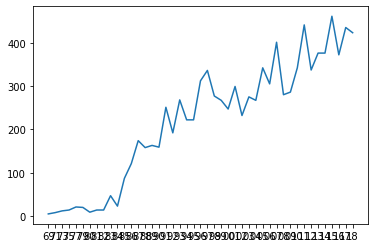

In [18]:
words_symbolic = ['logic', 'planning', 'control']
''' Add your code here '''
p_c2 = p_c1[p_c1['title'].str.contains('|'.join(words_symbolic))]
p_c22 = p_c2.groupby('year').count()
plt.plot(p_c22.index.str[-2:],p_c22.title)

In [21]:
p_c2.head()

,id,authors,year,title,conference
2049382,conf/iccv/KinoshitaL98,"['Keisuke Kinoshita', 'Michael Lindenbaum']",1998,robotic control partial visual information,iccv
2049444,conf/iccv/MartinFTM01,"['David R. Martin 0001', 'Charless C. Fowlkes'...",2001,a database human segmented natural images appl...,iccv
2049644,conf/iccv/VemuriG98,"['Baba C. Vemuri', 'Yanlin Guo']",1998,snake pedals geometric models physicsbased con...,iccv
2049682,conf/iccv/LobatonVAB11,"['Edgar J. Lobaton', 'Ramanarayan Vasudevan', ...",2011,robust topological features deformation invari...,iccv
2049687,conf/iccv/WatanabeHYNY01,"['Hiroki Watanabe', 'Hitoshi Hongo', 'Mamoru Y...",2001,control home appliances using face hand sign r...,iccv


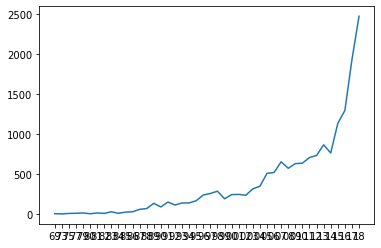

In [19]:
words_connectionist = ['deep', 'learning', 'feature', 'bayesian']
''' Add your code here '''
p_c3 = p_c1[p_c1['title'].str.contains('|'.join(words_connectionist))]
p_c32 = p_c3.groupby('year').count()
plt.plot(p_c32.index.str[-2:],p_c32.title)

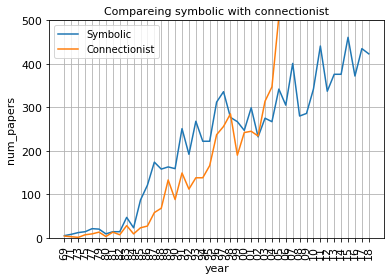

In [94]:
plt.plot(p_c22.index.str[-2:],p_c22.title, label = 'Symbolic')
plt.plot(p_c32.index.str[-2:],p_c32.title, label = 'Connectionist')
plt.ylim(0, 500) 
plt.title('Compareing symbolic with connectionist', fontsize = 11)
plt.xlabel('year', fontsize = 11)
plt.ylabel('num_papers', fontsize = 11)
plt.tick_params(labelsize=11)
plt.grid(True)
plt.legend(loc = 'upper left')
plt.xticks(rotation=90)
plt.show()